# Experiment 3

In [1]:
import pandas as pd

import quantstats as qs
from tinycta.portfolio import build_portfolio

In [2]:
# Load prices
prices = pd.read_csv("data/p_hashed.csv", index_col=0, parse_dates=True).ffill().truncate(before="1970-01-01")

We use the system:
$$\mathrm{CashPosition}=\frac{f(\mathrm{Price})}{\mathrm{Volatility(Returns)}}$$

This is very problematic:
* Prices may live on very different scales, hence trying to find a more universal function $f$ is almost impossible. The sign-function was a good choice as the results don't depend on the scale of the argument.
* Price may come with all sorts of spikes/outliers/problems.

We need a simple price filter process
* We compute volatility-adjusted returns, filter them and compute prices from those returns. 
* Don't call it Winsorizing in Switzerland. We apply Huber functions. 


In [3]:
def filter(price, volatility=32,clip=4.2, min_periods=300):    
    r = np.log(price).diff()
    vola = r.ewm(com=volatility, min_periods=min_periods).std()
    price_adj = (r/vola).clip(-clip, clip).cumsum()
    return price_adj

### Oscillators
* All prices are now following a standard arithmetic Brownian motion with std $1$.
* What we want is the difference of two moving means (exponentially weighted) to have a constant std regardless of the two lengths.
* An oscillator is the **scaled difference of two moving averages**.


In [4]:
import numpy as np
def osc(prices, fast=32, slow=96, scaling=True):
    diff = prices.ewm(com=fast-1).mean() - prices.ewm(com=slow-1).mean()
    if scaling:
        s = diff.std()
    else:
        s = 1

    return diff/s

In [5]:
from numpy.random import randn
import pandas as pd
price = pd.Series(data=randn(100000)).cumsum()

o = osc(price, 40, 200, scaling=True)
print("The std for the oscillator (Should be close to 1.0):")
print(np.std(o))

The std for the oscillator (Should be close to 1.0):
0.9999949999875


In [6]:
#from pycta.signal import osc

# take two moving averages and apply tanh
def f(price, slow=96, fast=32, vola=96, clip=3):
    # construct a fake-price, those fake-prices have homescedastic returns
    price_adj = filter(price, volatility=vola, clip=clip)
    # compute mu
    mu = np.tanh(osc(price_adj, fast=fast, slow=slow))
    return mu/price.pct_change().ewm(com=slow, min_periods=300).std()

In [7]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
left_box = VBox([Label("Fast Moving Average"), Label("Slow Moving Average"), Label("Volatility"), Label("Winsorizing")])
right_box = VBox([fast, slow, vola, winsor])
HBox([left_box, right_box])

In [8]:
portfolio = build_portfolio(prices=prices, position=prices.apply(f, slow=slow.value, fast=fast.value, vola=vola.value, clip=winsor.value))

/home/thomas/.pyenv/versions/3.10.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


                    Strategy
------------------  ----------
Start Period        1990-01-02
End Period          2023-04-14
Risk-Free Rate      0.0%
Time in Market      96.0%

Cumulative Return   53.55%
CAGR﹪              1.3%

Sharpe              0.79
Prob. Sharpe Ratio  100.0%
Sortino             1.12
Sortino/√2          0.79
Omega               1.16

Max Drawdown        -5.58%
Longest DD Days     2275

Gain/Pain Ratio     0.16
Gain/Pain (1M)      0.91

Payoff Ratio        0.96
Profit Factor       1.16
Common Sense Ratio  1.17
CPC Index           0.61
Tail Ratio          1.01
Outlier Win Ratio   4.01
Outlier Loss Ratio  4.03

MTD                 0.15%
3M                  0.29%
6M                  -0.8%
YTD                 0.17%
1Y                  0.8%
3Y (ann.)           1.57%
5Y (ann.)           0.46%
10Y (ann.)          0.94%
All-time (ann.)     1.3%

Avg. Drawdown       -0.33%
Avg. Drawdown Days  43
Recovery Factor     9.59
Ulcer Index         0.02
Serenity Index      1.17


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


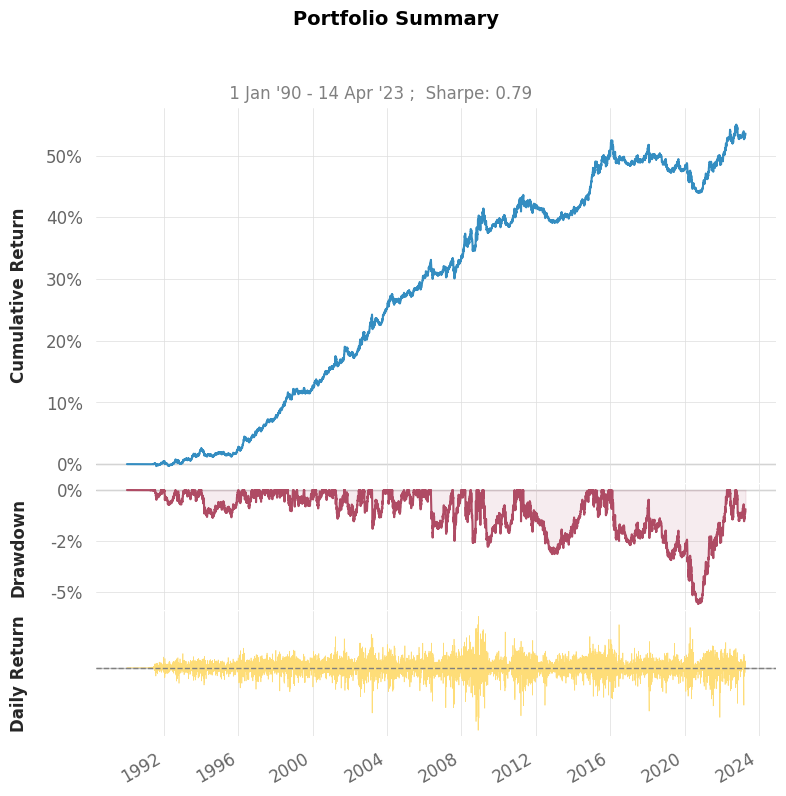

/home/thomas/.pyenv/versions/3.10.10/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


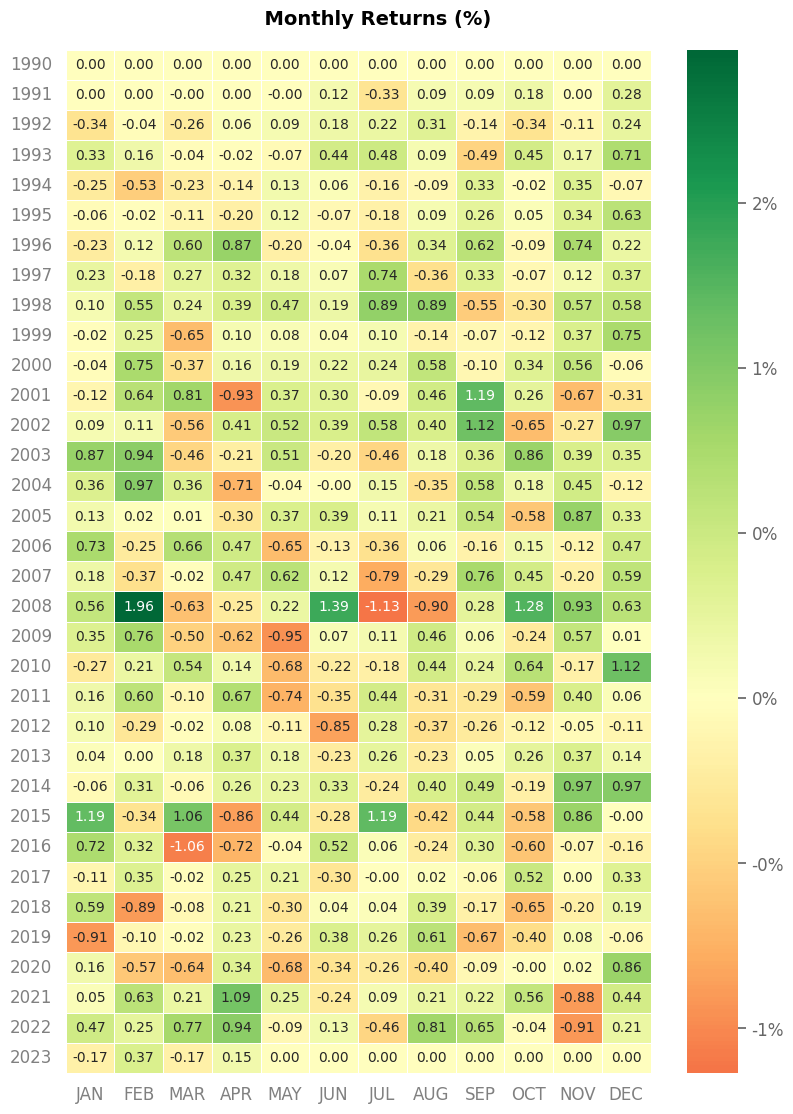

In [9]:
qs.reports.basic(portfolio.returns(init_capital=10000))

This system is still **univariate** and lacks **integrated risk management**:

$$\mathrm{CashPosition}=\frac{f(\mathrm{Filter}(\mathrm{Price}))}{\mathrm{Volatility(Returns)}}=\frac{\mu}{\mathrm{Volatility}}$$

Some hedge funds stop here. All energy goes into constructing $\mu$.

* Suitable as it is possible to add/remove additional systems on the fly.
* A typical CTA would run with a set of $5$ or $6$ functions $f$ acting on approx. $100$ assets. 
* Organisation by asset group.
* Scaled signals make it easy to apply functions such as $\tanh$ or combine various signals in a regression problem.